# Up-Sampling in Per-Pixel Predictions notebook
<table align="left"><td>
   <a target="_blank"  href="https://colab.research.google.com/github/nsirons/UpsamplingConv/blob/master/main.ipynb">
     <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
   </a>
 </td><td>
   <a target="_blank"  href="https://github.com/nsirons/UpsamplingConv/blob/master/main.ipynb">
     <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
 </td></table>
 


Nowadays, there are many available libraries such as OpenCV, scipy.ndimage, and others that already have implemented and optimized versions. However, the goal of this notebook is to show how it is done "by-hand" and what could be modified. You are free to load your sample images and try different scale factors and kernels.

 To use these notebooks you will need the following libaries:
- cv2- scipy
- numpy
- matplotlib

The easiest way to run this notebook is in Google Colab. Google Colab already has all the required dependencies install so you can just run it.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

If you run the notebook in colab you have to upload the image manual or clone the our repo:
`git clone https://github.com/nsirons/UpsamplingConv.git`

You can then find the images in the folder `UpsamplingConv`. You can also set `PATH_TO_THE_IMAGE` to any image on the internet.

In [2]:
SCALE_FACTOR = 2  # Factor to which image would be upsampled (must be int)
INTERPOLATION_TYPE = 'LANCZOS'  #  Interpolation type
PATH_TO_THE_IMAGE = 'car_large.jpg'  # The path to the image you want to use. This can be a URL.
#PATH_TO_THE_IMAGE = "https://www.3dhype.nl/leden/200/small_G55132d9468670.jpg" # Use this image if your run it in colab 

Image shape (132, 200, 3)


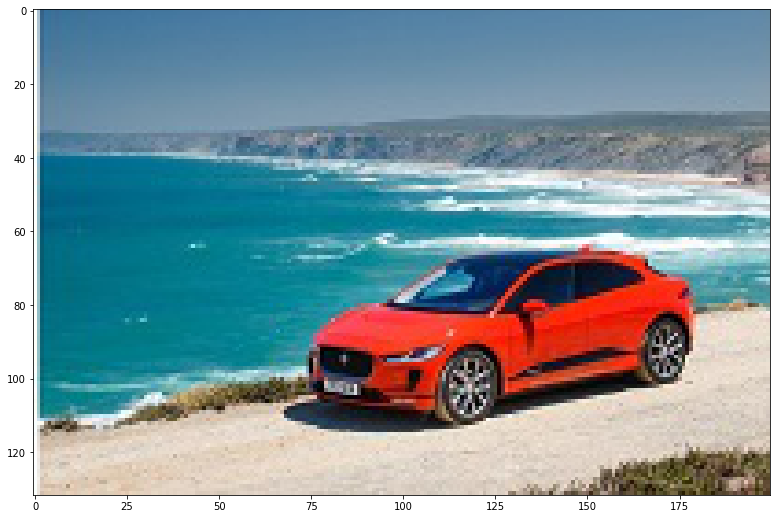

In [3]:
if "http" in PATH_TO_THE_IMAGE:
  req = urlopen(PATH_TO_THE_IMAGE)
  arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
  img = cv.imdecode(arr, -1)
else:
  img = cv.imread(PATH_TO_THE_IMAGE)

img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_figsize = img.shape[0] / 10, img.shape[1] / 10

print("Image shape", img_rgb.shape)
plt.figure(figsize=img_figsize)
plt.imshow(img_rgb)
plt.show()

In the next cell, we apply interpolation step 1 & 2 to the image (for more information read section 2 in the chapter Up-Sampling in Per-Pixel Predictions). The black areas in the picture are pixels that have received any values yet. In the next part of the notebook, we are going to determine these values using interpolation.

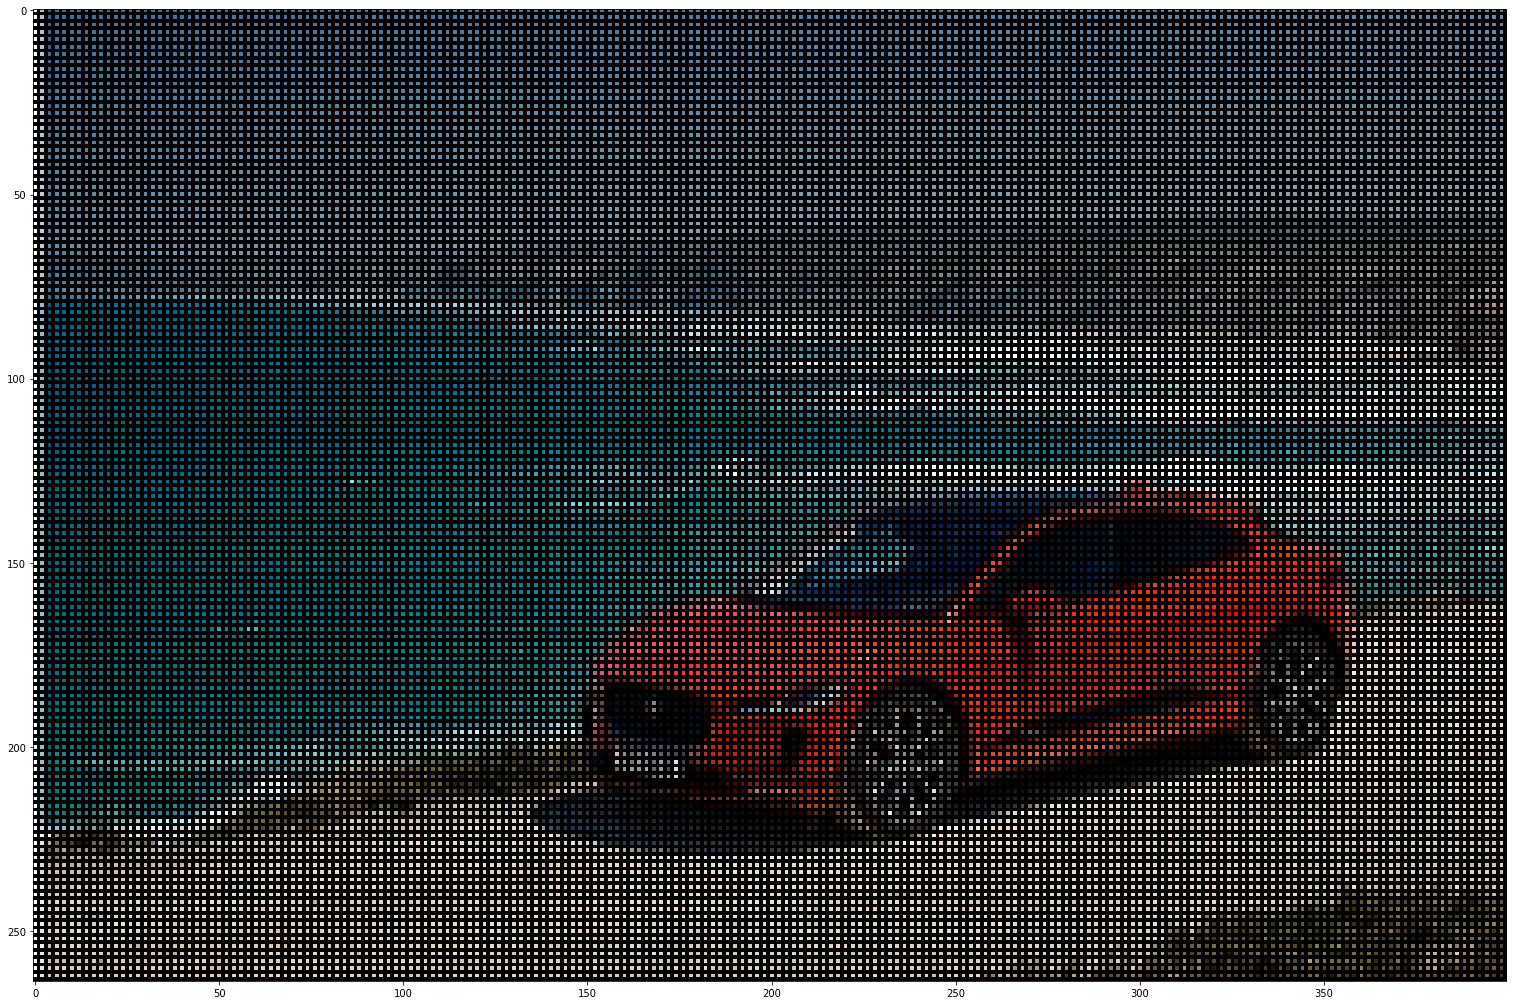

In [4]:
def upsample(img, f:int):
    """Put f amount of zeros in between of original values""" 
    if len(img.shape) == 3:
        img_upsample = np.zeros((f*img.shape[0], f*img.shape[1], img.shape[2]))
    else:
        img_upsample = np.zeros((f*img.shape[0], f*img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if len(img.shape) == 3:
                img_upsample[f*i,f*j,:] = img[i,j,:]
            else:
                img_upsample[f*i,f*j] = img[i,j]
    return img_upsample / 255.  # scale image to [0, 1]

fig_size_scaled = lambda x, y: (x[0] * y, x[1] * y)

# show upsampled and scaled version
img_scaled  = upsample(img_rgb,SCALE_FACTOR)
fig = plt.figure(figsize=fig_size_scaled(img_figsize, SCALE_FACTOR))  
plt.imshow(img_scaled)
plt.show()

In this section, we demonstrate the interpolation results for the following of OpenCV interpolation methods:
* cv.INTER_NEAREST - a nearest-neighbor interpolation
* cv.INTER_LINEAR - a bilinear interpolation (used by default)
* cv.INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
* cv.INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
* cv.INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood

source: https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html

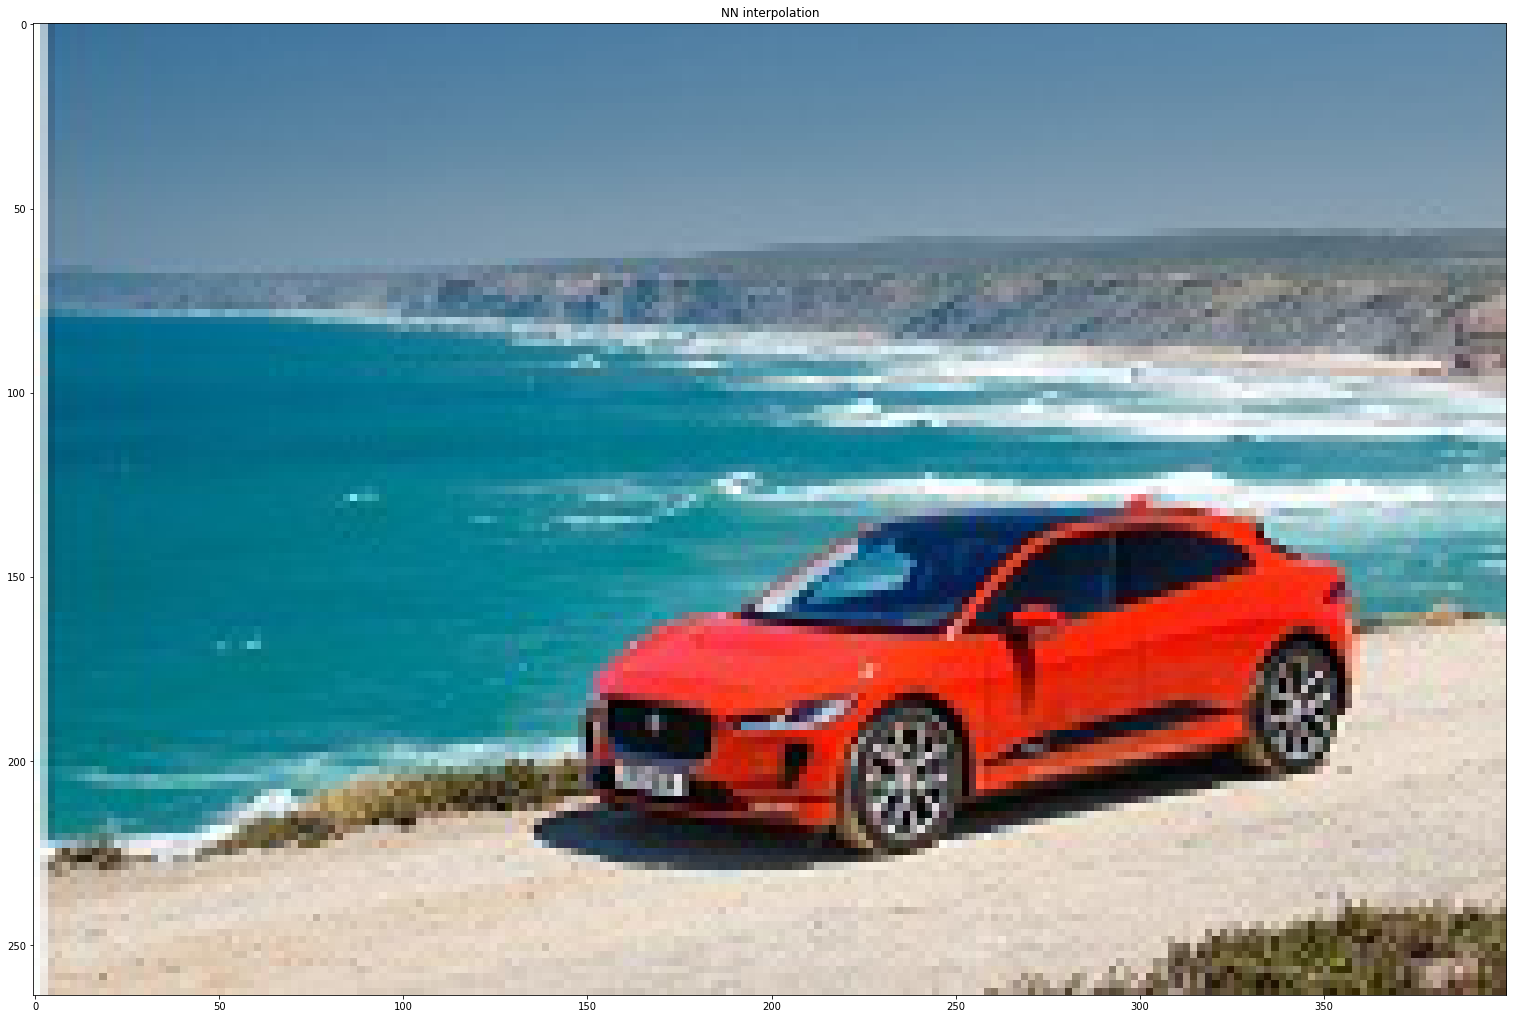

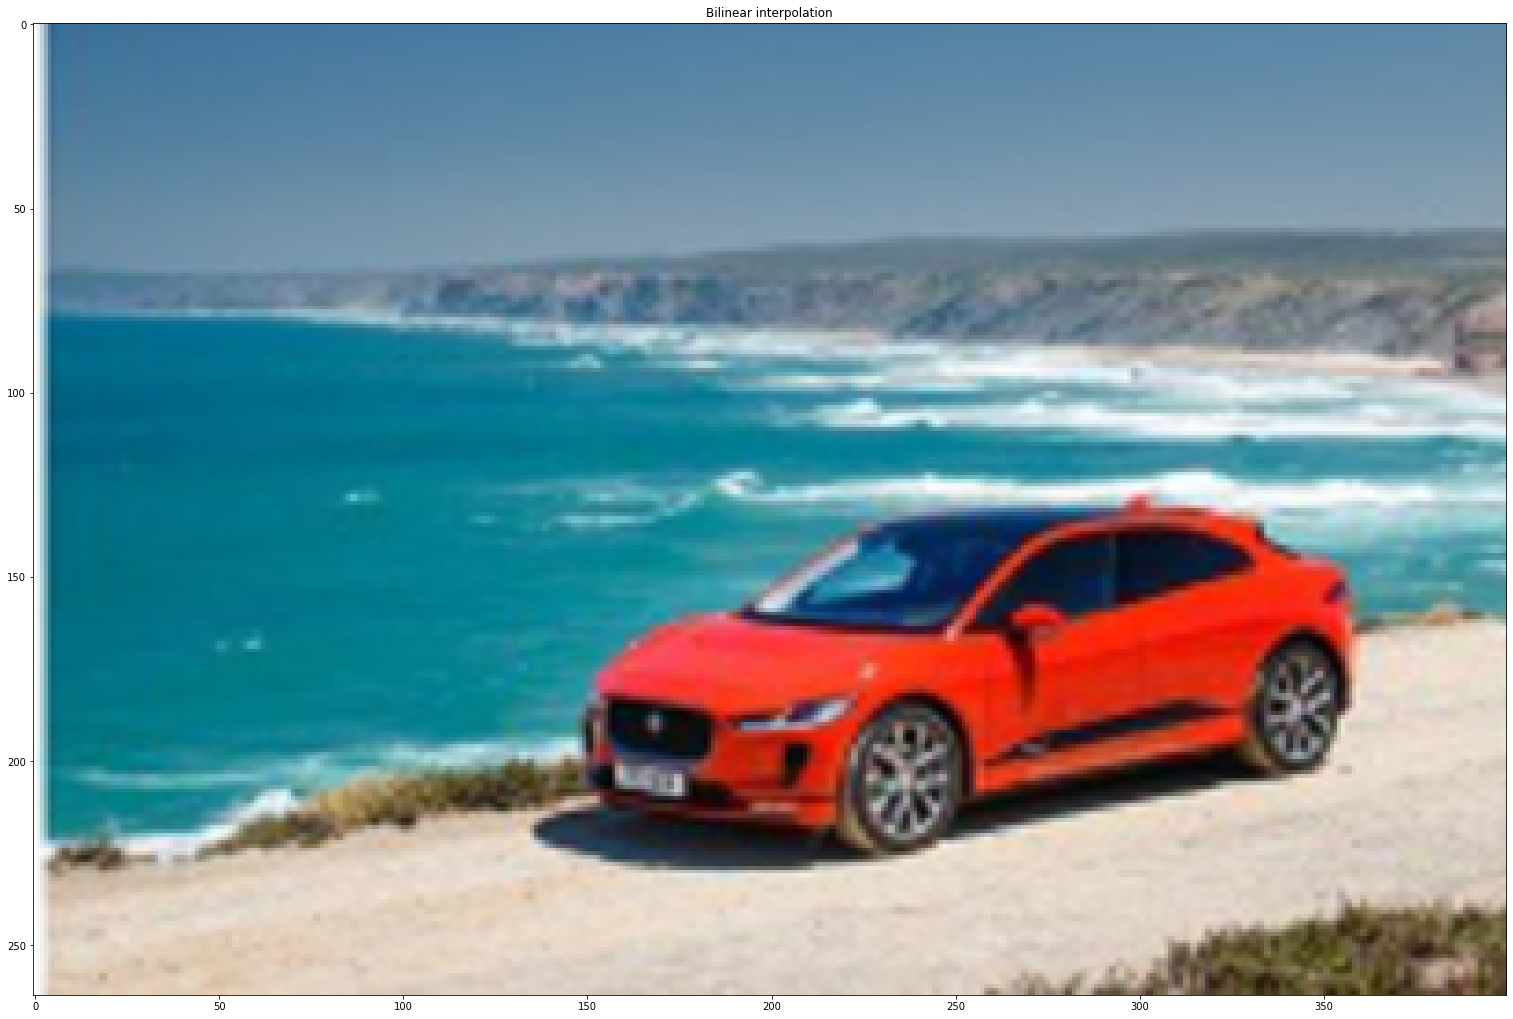

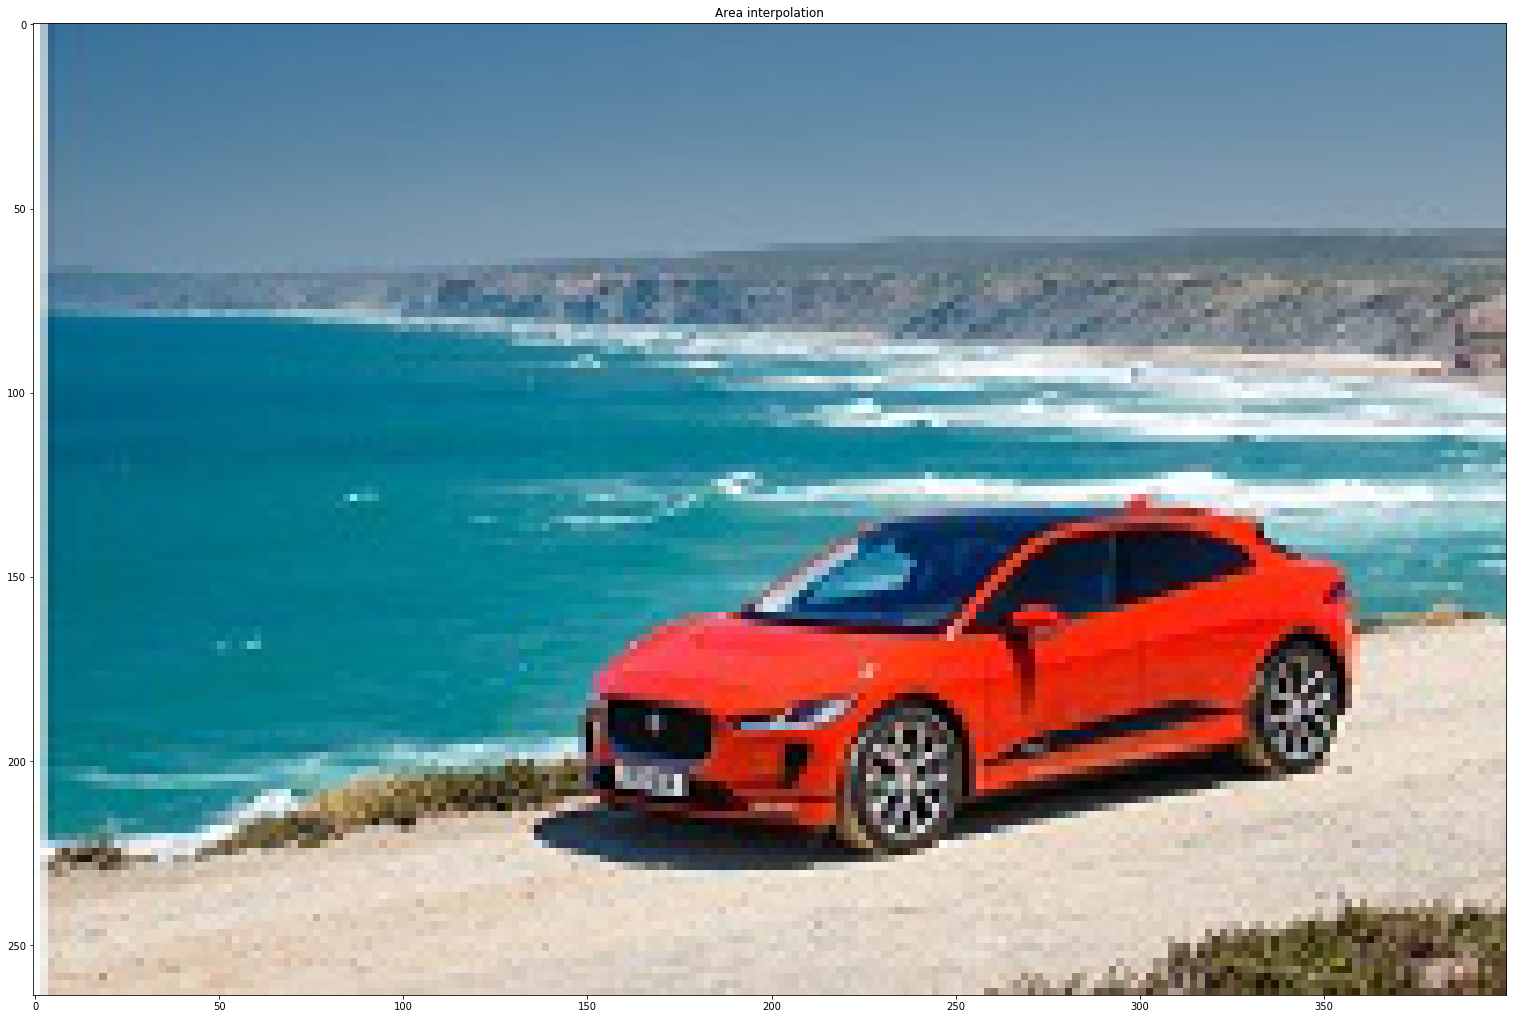

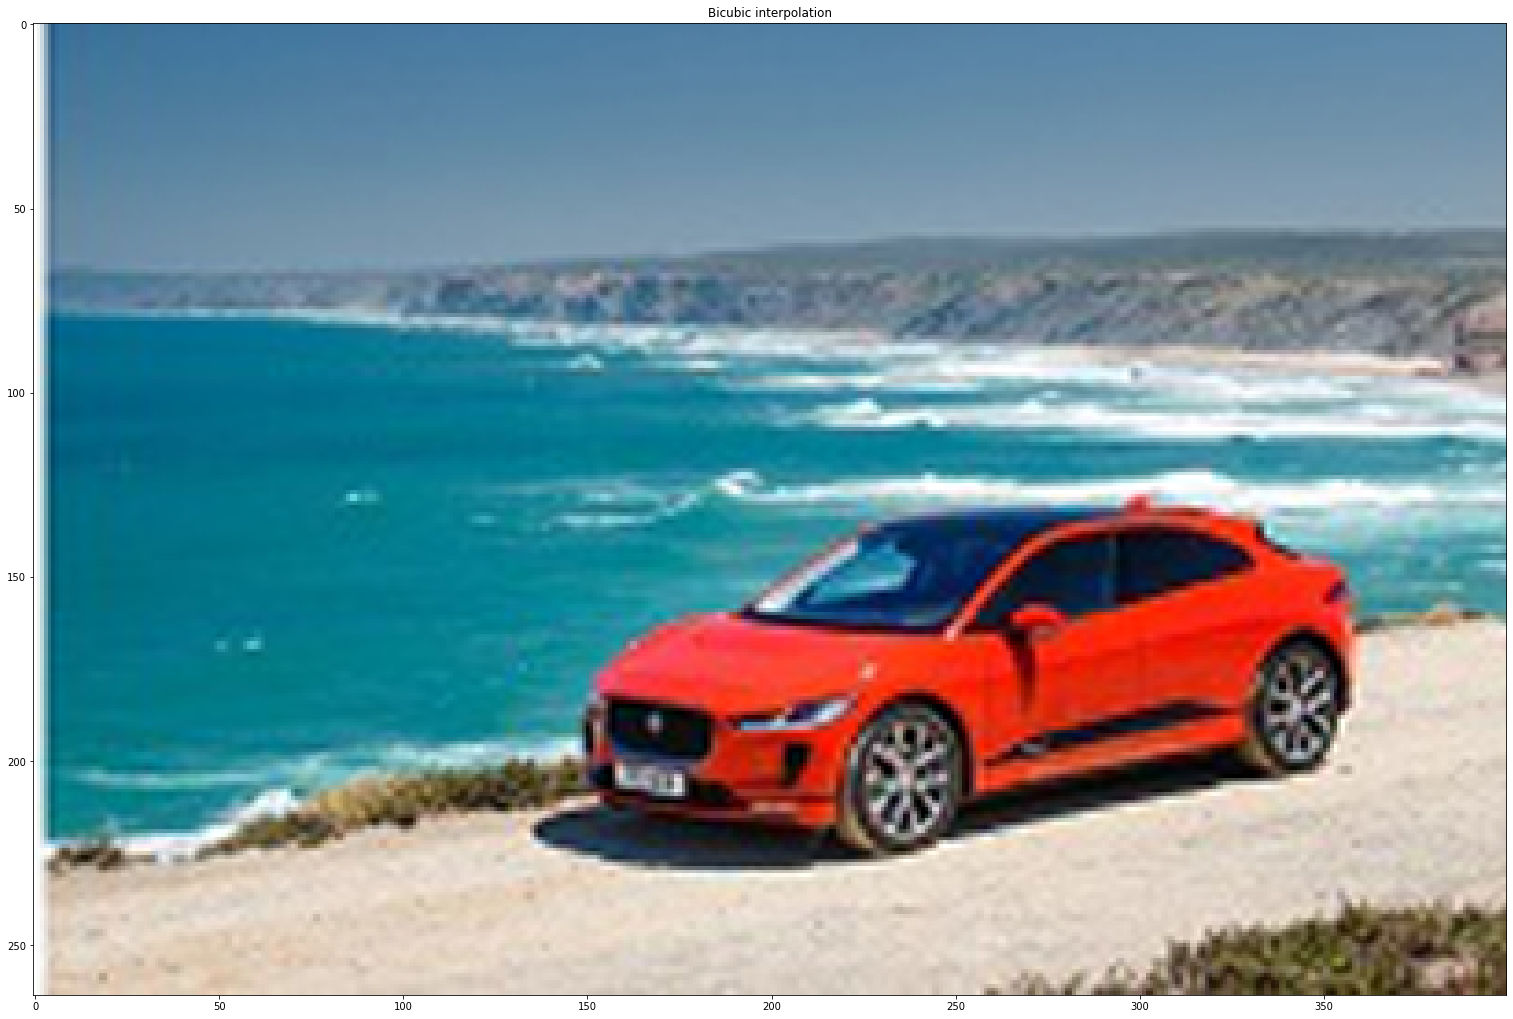

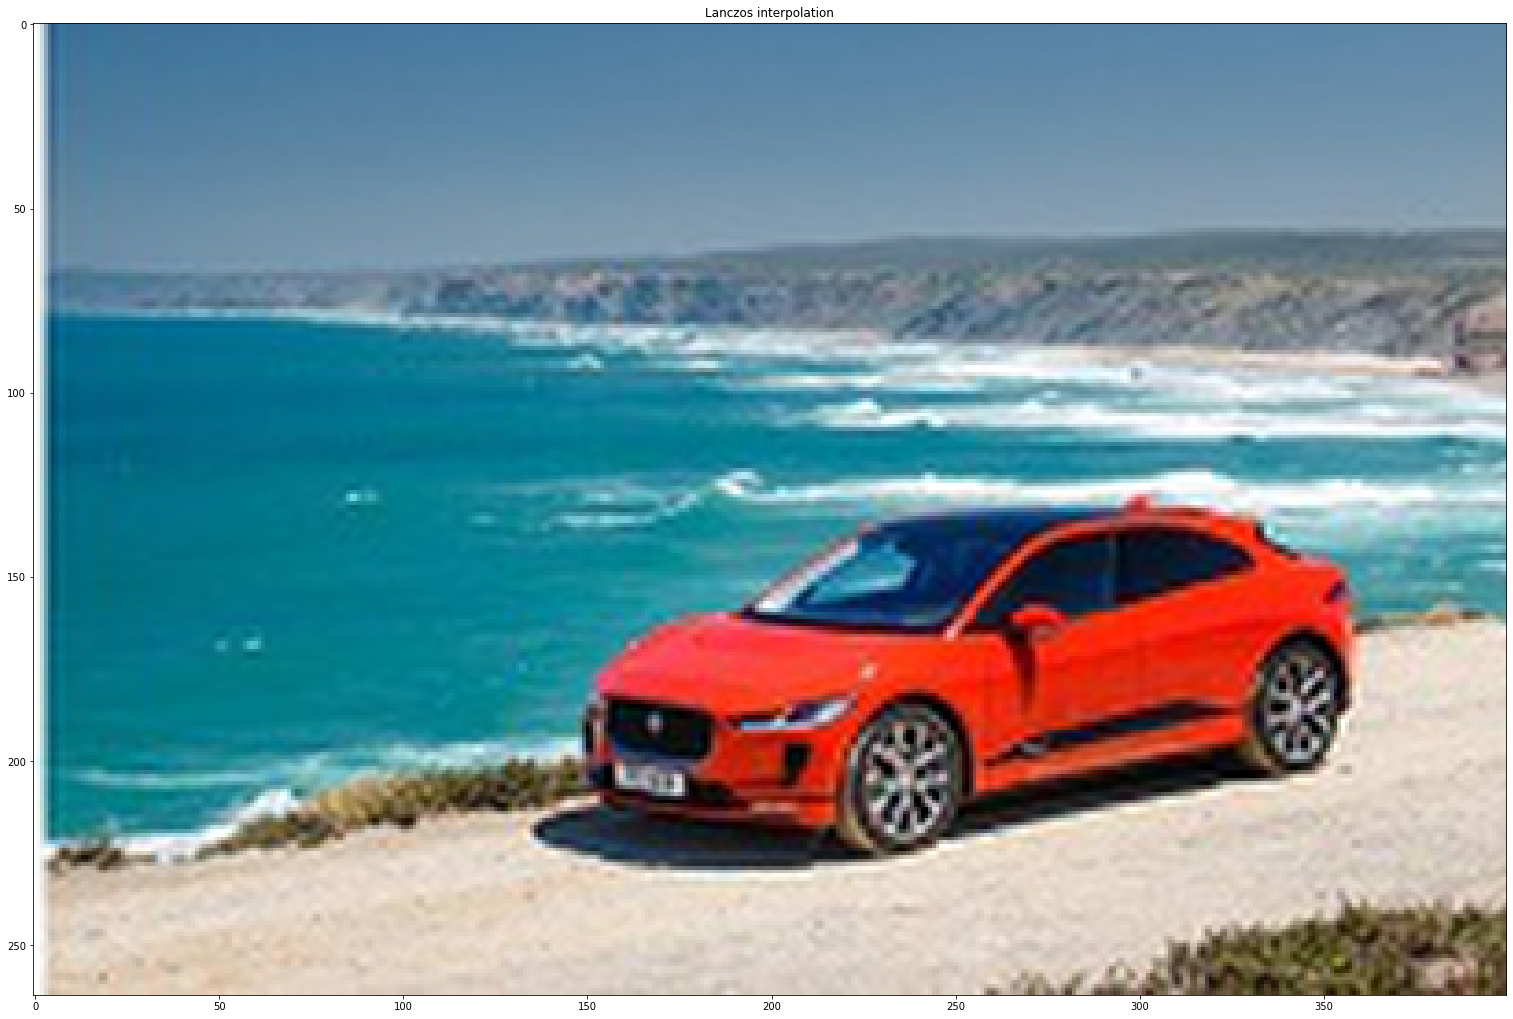

In [5]:
methods = [
    ("NN interpolation",cv.INTER_NEAREST),
    ("Bilinear interpolation",cv.INTER_LINEAR),
    ("Area interpolation",cv.INTER_AREA),
    ("Bicubic interpolation",cv.INTER_CUBIC),
    ("Lanczos interpolation",cv.INTER_LANCZOS4)
]

for title, iterp in methods:
    plt.figure(figsize=fig_size_scaled(img_figsize, SCALE_FACTOR))
    plt.imshow(cv.resize(img_rgb, dsize=(0,0), fx=SCALE_FACTOR, fy=SCALE_FACTOR, interpolation=iterp))
    plt.title(title)
    plt.show()


As it was mentioned in the chapter, the interpolation method strongly depends on the type of kernel which is used. Here we will explore different kernels and show their interpolation results.

In the figure below you can see how kernels look in continuous space. To construct a discrete kernel, values at the red markers would be picked.

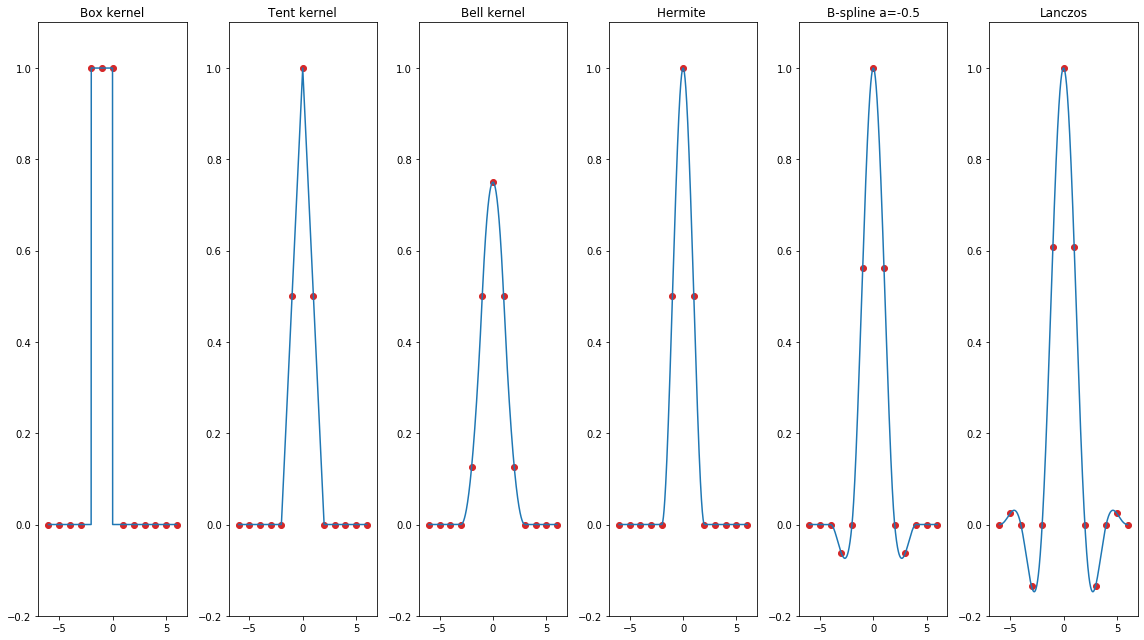

In [6]:
box_kernel = lambda x: (((-x/2 <= 0.5) & (-x/2>=0))).astype(int)
tent_kernel = lambda x: np.clip(1-np.abs(x), 0, 1)

def tent_kernel(x):
    x_new = np.zeros(x.shape)
    cond1 = np.abs(x) < 1.
    x_cond1 = x[cond1]
    x_new[cond1] = 1- np.abs(x_cond1)
    return x_new
    
def bell_kernel(x):
    x_new = np.zeros(x.shape)
    cond1 = np.abs(x) <= 0.5
    x_cond1 = x[cond1]
    x_new[cond1] = 0.75 - (x_cond1 ** 2)
    
    cond2 = (np.abs(x) > 0.5) & (np.abs(x) < 1.5)
    x_cond2 = x[cond2]
    x_new[cond2] = 0.5 * (np.abs(x_cond2) - 1.5)**2
    return x_new

def bspline_kernel(x, a):
    x_new = np.zeros(x.shape)
    
    cond1 = np.abs(x) <= 1
    x_cond1 = x[cond1]
    x_new[cond1]  = (a+2)*np.abs(x_cond1**3)-(a+3)*(np.abs(x_cond1**2)) + 1
    
    cond2 = (np.abs(x) > 1) & (np.abs(x) < 2)
    x_cond2 = x[cond2]
    x_new[cond2] = a*np.abs(x_cond2**3) - 5*a*np.abs(x_cond2**2) + 8*a*np.abs(x_cond2)- 4*a
    return x_new

def lanczos_kernel(x, a=3):
    x_new = np.zeros(x.shape)
    cond1 = np.abs(x) <= a
    x_cond1 = x[cond1]
    x_new[cond1]=np.sinc(x)*np.sinc(x/a)
    return x_new

x = np.linspace(-6,6, 1001)
xx = np.arange(-6,7,1)

fig = plt.figure(figsize=(16,9))

plt.subplot(161)
plt.plot(x, box_kernel(x/2))
plt.scatter(xx, box_kernel(xx/2), marker='o', c='tab:red')
plt.title("Box kernel")
plt.ylim(-0.2, 1.1)

plt.subplot(162)
plt.plot(x, tent_kernel(x/2))
plt.scatter(xx, tent_kernel(xx/2), marker='o', c='tab:red')
plt.title("Tent kernel")
plt.ylim(-0.2, 1.1)

plt.subplot(163)
plt.plot(x, bell_kernel(x/2))
plt.scatter(xx, bell_kernel(xx/2), marker='o', c='tab:red')
plt.title("Bell kernel")
plt.ylim(-0.2, 1.1)

plt.subplot(164)
plt.plot(x, bspline_kernel(x/2, 0))
plt.scatter(xx, bspline_kernel(xx/2, 0), marker='o', c='tab:red')
plt.title("Hermite ")
plt.ylim(-0.2, 1.1)

plt.subplot(165)
plt.plot(x, bspline_kernel(x/2, -0.5))
plt.scatter(xx, bspline_kernel(xx/2, -0.5), marker='o', c='tab:red')
plt.title("B-spline a=-0.5")
plt.ylim(-0.2, 1.1)

plt.subplot(166)
plt.plot(x, lanczos_kernel(x/2, 3))
plt.scatter(xx, lanczos_kernel(xx/2, 3), marker='o', c='tab:red')
plt.title("Lanczos")
plt.ylim(-0.2, 1.1)


plt.tight_layout()
plt.show()

Size of the kernel depends on the order of the interpolation and upsampling scale.

In [7]:
def generate_kernel_2d(kernel):
    return kernel.reshape((-1,1)) @ kernel.reshape((1,-1))

if INTERPOLATION_TYPE == 'NN':
    f = SCALE_FACTOR-1
    x = np.arange(-f,f+1,1)
    kernel = box_kernel(x/SCALE_FACTOR)
elif INTERPOLATION_TYPE == 'LINEAR':
    f = SCALE_FACTOR-1
    x = np.arange(-f,f+1,1)
    kernel = tent_kernel(x/SCALE_FACTOR)
elif INTERPOLATION_TYPE == 'BELL':
    f = SCALE_FACTOR*2-2
    x = np.arange(-f,f+1,1)
    kernel = bell_kernel(x/SCALE_FACTOR)
elif INTERPOLATION_TYPE == 'HERMITE':
    f = SCALE_FACTOR*2 -1
    x = np.arange(-f,f+1,1)
    kernel = bspline_kernel(x/5, 0.0)
elif INTERPOLATION_TYPE == 'CUBIC':
    f = SCALE_FACTOR*2 - 1
    x = np.arange(-f,f+1,1)
    kernel = bspline_kernel(x/SCALE_FACTOR, -0.75)
elif INTERPOLATION_TYPE == 'LANCZOS':
    f = SCALE_FACTOR*2 + 2
    x = np.arange(-f, f+1, 1)
    kernel = lanczos_kernel(x/SCALE_FACTOR, 3)
else:
    print(f"Unknown kernel {INTERPOLATION_TYPE}")
    kernel = []

print(INTERPOLATION_TYPE)
print(f"kernel 1D")
print(np.round(kernel, 3))
kernel = generate_kernel_2d(kernel)
print(f"kernel 2D")
print(np.round(kernel,2))

LANCZOS
kernel 1D
[ 0.     0.024 -0.    -0.135  0.     0.608  1.     0.608  0.    -0.135
 -0.     0.024  0.   ]
kernel 2D
[[ 0.    0.   -0.   -0.    0.    0.    0.    0.    0.   -0.   -0.    0.
   0.  ]
 [ 0.    0.   -0.   -0.    0.    0.01  0.02  0.01  0.   -0.   -0.    0.
   0.  ]
 [-0.   -0.    0.    0.   -0.   -0.   -0.   -0.   -0.    0.    0.   -0.
  -0.  ]
 [-0.   -0.    0.    0.02 -0.   -0.08 -0.14 -0.08 -0.    0.02  0.   -0.
  -0.  ]
 [ 0.    0.   -0.   -0.    0.    0.    0.    0.    0.   -0.   -0.    0.
   0.  ]
 [ 0.    0.01 -0.   -0.08  0.    0.37  0.61  0.37  0.   -0.08 -0.    0.01
   0.  ]
 [ 0.    0.02 -0.   -0.14  0.    0.61  1.    0.61  0.   -0.14 -0.    0.02
   0.  ]
 [ 0.    0.01 -0.   -0.08  0.    0.37  0.61  0.37  0.   -0.08 -0.    0.01
   0.  ]
 [ 0.    0.   -0.   -0.    0.    0.    0.    0.    0.   -0.   -0.    0.
   0.  ]
 [-0.   -0.    0.    0.02 -0.   -0.08 -0.14 -0.08 -0.    0.02  0.   -0.
  -0.  ]
 [-0.   -0.    0.    0.   -0.   -0.   -0.   -0.   -0.    0.   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


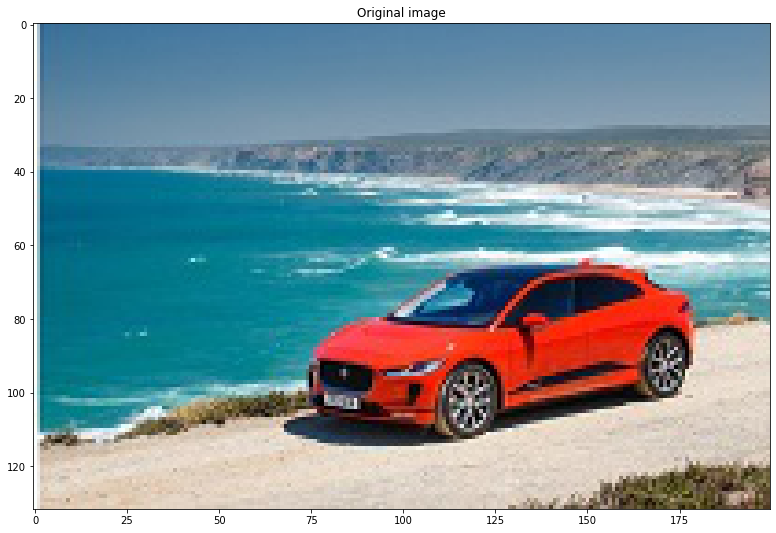

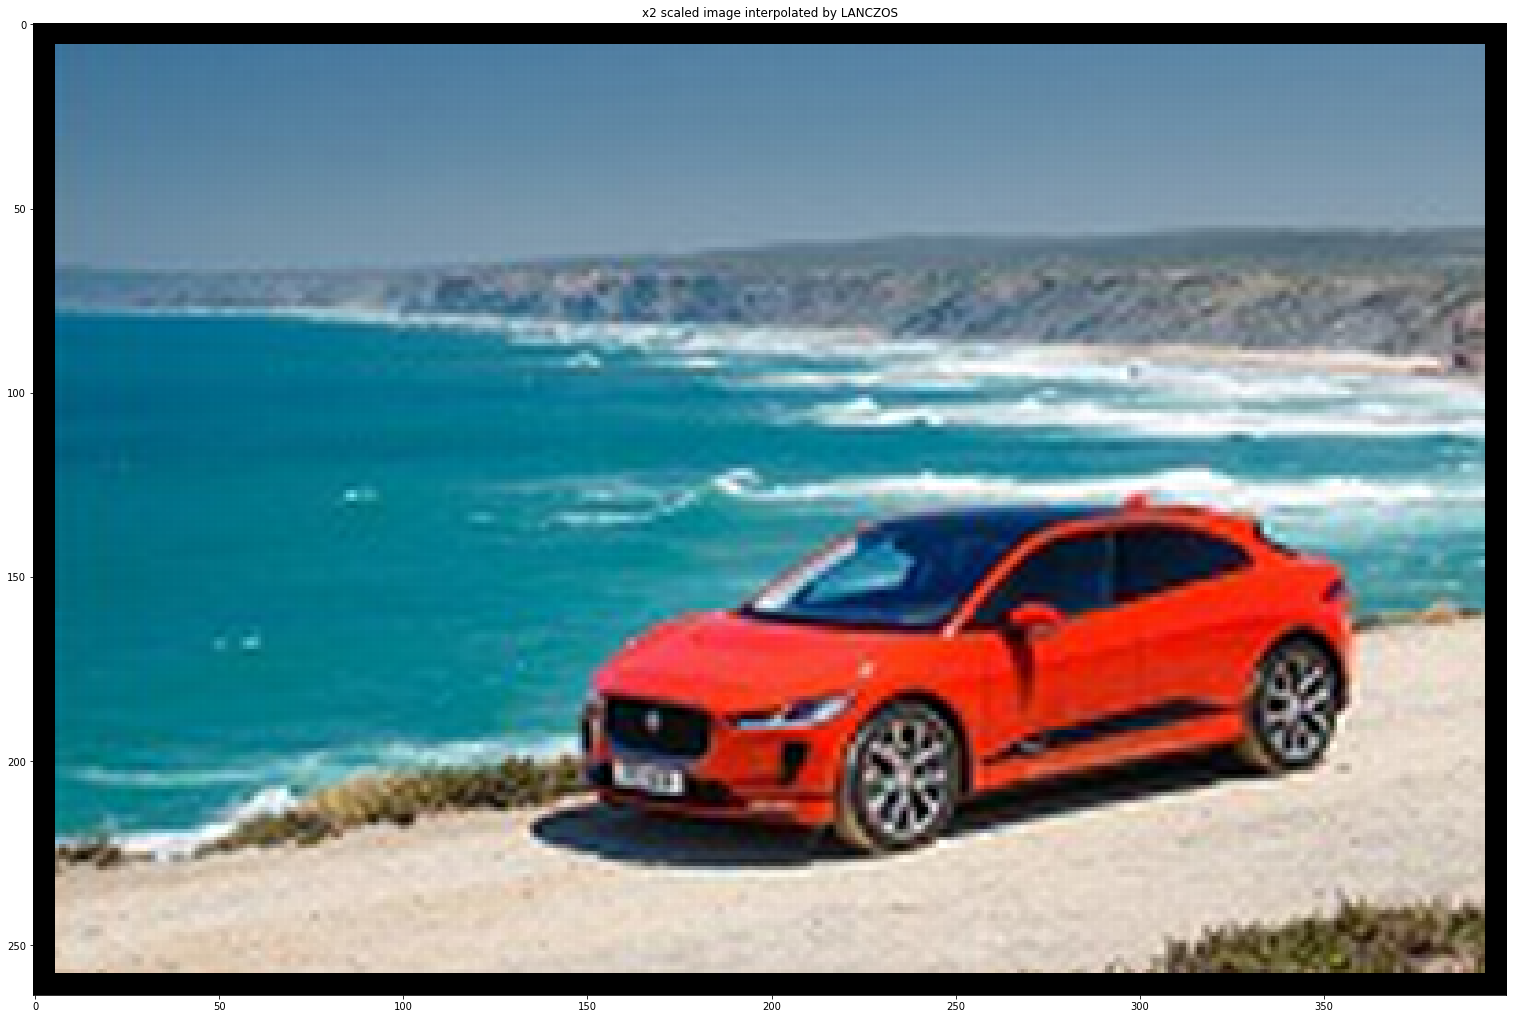

In [8]:
def convolution_2d(img, kernel):
    new_image = np.zeros(img.shape)
    side = len(kernel)//2  # ignore edges 
    for y in range(side, len(img)-side):
        for x in range(side, len(img[0])-side):
            new_image[y,x] = np.sum(kernel * img[y-side:y+side+1, x-side:x+side+1])
    return new_image

img_up = np.zeros(img_scaled.shape)
for channel in range(img_rgb.shape[2]):
    img_up[:,:,channel] = convolution_2d(img_scaled[:,:,channel], kernel)

plt.figure(figsize=img_figsize)
plt.imshow(img_rgb)
plt.title("Original image")
plt.figure(figsize=fig_size_scaled(img_figsize, SCALE_FACTOR))
plt.title(f"x{SCALE_FACTOR} scaled image interpolated by {INTERPOLATION_TYPE}")
plt.imshow(img_up)
plt.show()